# Neural networks with PyTorch

PyTorch has a nice module nn that provides a nice way to efficiently build large neural networks.

In [23]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels.

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us.

In [24]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [25]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

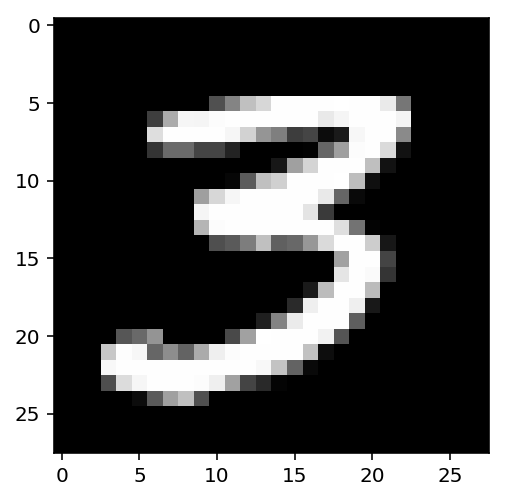

In [26]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 1, 28, 28)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

Here we need to build 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [30]:
## Your solution
inputs = images.view(images.shape[0], -1)

print(inputs.shape)

# Activation function
def sigmoid(x):
    y =  1 / (1 + torch.exp(-x))
    return y

W1 = torch.randn(784, 256)
B1 = torch.randn(256)

W2 = torch.randn(256, 10)
B2 = torch.randn(10)

h = sigmoid(torch.mm(inputs, W1) + B1)

# output of your network, should have shape (64,10)
out = torch.mm(h, W2) + B2
print(out.shape)

torch.Size([64, 784])
torch.Size([64, 10])


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to.

To calculate the probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

> **Exercise:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way PyTorch will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `dim` keyword in `torch.sum`. Setting `dim=0` takes the sum across the rows while `dim=1` takes the sum across the columns.

In [37]:
## Solution

def softmax(x):
    probabilities = torch.exp(x) / (torch.sum(torch.exp(x), dim=1)).view(-1, 1)
    return probabilities

probabilities = softmax(out)

# Checking the shape
probabilities.shape

# Check
probabilities.sum(dim=1)



tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])